In [47]:
# Get first file name
import os

def get_file_name():
    with open ('./data/chord_data_1217/audio/filelist.txt', 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            return line
        
def get_file_name_list():
    with open ('./data/chord_data_1217/audio/filelist.txt', 'r') as f:
        lines = f.readlines()
        file_list = []
        for line in lines:
            line = line.strip()
            file_list.append(line)
        return file_list

def trim_file_name(file_name):
    return os.path.splitext(os.path.basename(file_name))[0]

trim_file_name(get_file_name())

'TR6R91L11C8A40D710'

In [110]:
import numpy as np
import librosa



src = librosa.load(os.path.join('./data/chord_data_1217/audio/', f'{filename}.mp3'), sr=None)[0]

log_cqt = librosa.amplitude_to_db(
    np.abs(
        librosa.cqt(src, sr=SR, hop_length=hop_length, n_bins=n_bins, bins_per_octave=bins_per_octave, fmin=librosa.note_to_hz('C1'))
    )
)

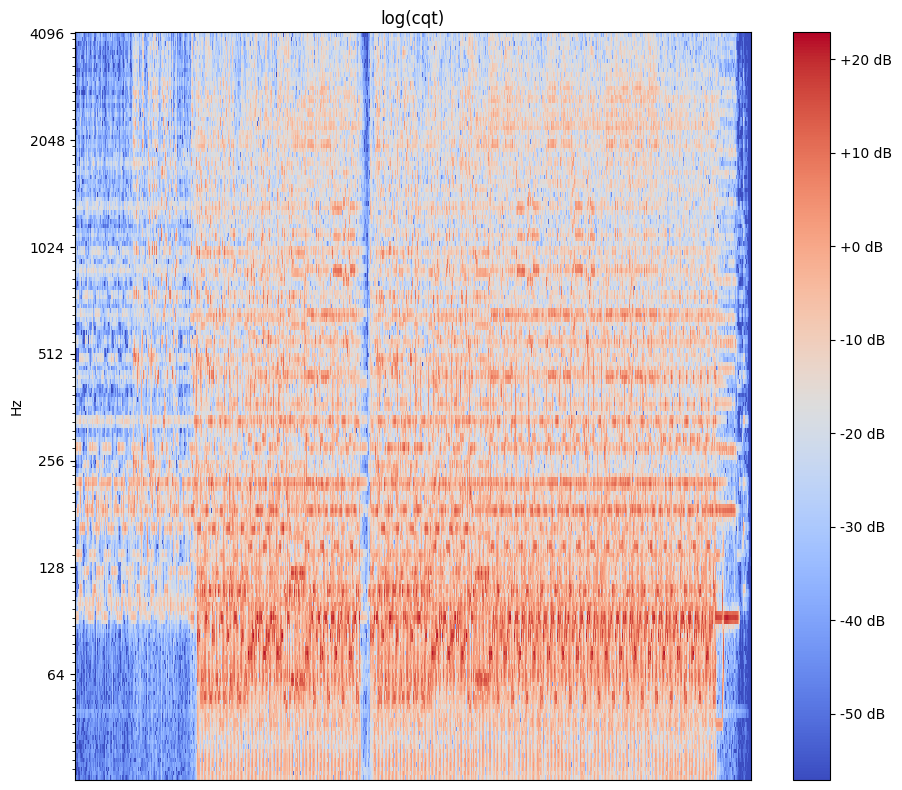

In [111]:
from librosa.display import specshow
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 2)
img = librosa.display.specshow(log_cqt, y_axis='cqt_hz', sr=SR, hop_length=hop_length, bins_per_octave=bins_per_octave)
plt.colorbar(img, format="%+2.f dB")
plt.title('log(cqt)')
plt.tight_layout()
plt.show()

In [179]:
from scipy.signal import correlate
import jams
import librosa

import numpy as np

SR = 44100
hop_length = 512
n_bins = 24*7
bins_per_octave = 24

def get_chord_annotation(file_name):
    jam = jams.load(os.path.join('./data/chord_data_1217/references_v2/', f'{file_name}.jams'))
    chord_ann = jam.annotations.search(namespace="chord")[0]
    return chord_ann.data

def convert_chords_to_binary(log_cqt, chords, sr, hop_length, duration):
    # Create a binary vector for chord changes where 1 indicates a chord change and 0 indicates no change
    # Assuming a time resolution similar to the spectrogram hop length
    binary_chords = np.zeros(log_cqt.shape[1])
    for chord in chords:
        start = librosa.time_to_frames(chord.time, sr=sr, hop_length=hop_length)
        # if start < len(binary_chords):
        binary_chords[start] = 1
    return binary_chords

def get_max_corr(filename):
    errored_files = []

    src = librosa.load(os.path.join('./data/chord_data_1217/audio/', f'{filename}.mp3'), sr=None)[0]
    log_cqt = librosa.amplitude_to_db(
        np.abs(
            librosa.cqt(src, sr=SR, hop_length=hop_length, n_bins=n_bins, bins_per_octave=bins_per_octave, fmin=librosa.note_to_hz('C1'))
        )
    )
    chord_ann = get_chord_annotation(filename)
    binary_chords = convert_chords_to_binary(log_cqt, chord_ann, SR, hop_length, len(src))
    
    delta = librosa.feature.delta(log_cqt) # (24*7, Frames)
    delta_magnitude = np.sqrt(np.sum(delta**2, axis=0)) # (Frames)

    # Standardize the features
    delta_magnitude = (delta_magnitude - np.mean(delta_magnitude)) / np.std(delta_magnitude)
    binary_chords = (binary_chords - np.mean(binary_chords)) / np.std(binary_chords)
    
    # Get cross-correlation of chord changes and log-cqt delta  
    corr = correlate(delta_magnitude, binary_chords, mode='full')
    
    lags = np.arange(-len(binary_chords)+1, len(binary_chords))
    max_lag = lags[np.argmax(corr)]
    
    return max_lag, corr, lags, len(binary_chords), errored_files


Maximum correlation lag: -93 frames
(45979,) (45979,)


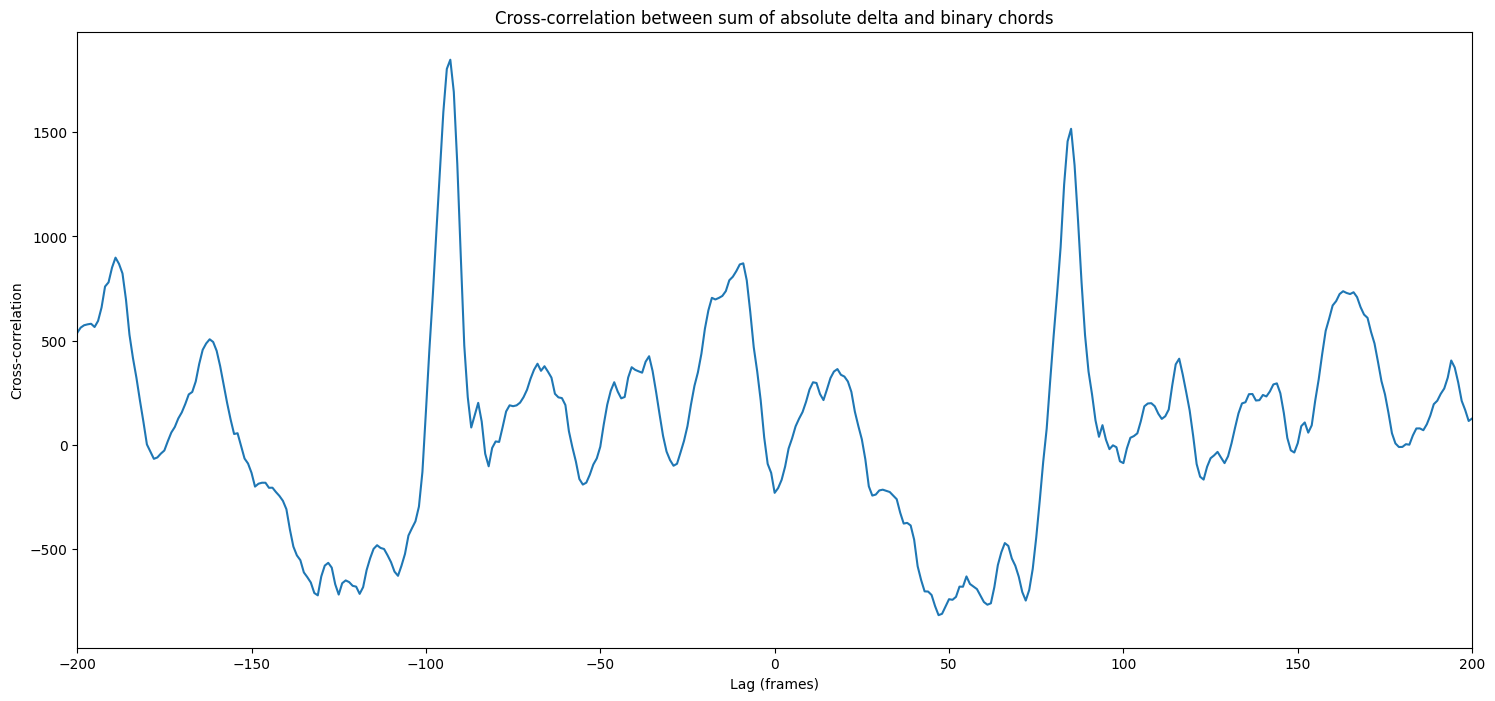

In [195]:
filename = 'TRZUUDG149E37F179C'

max, corr, lags, _, _ = get_max_corr(filename)
print(f'Maximum correlation lag: {max} frames')
plt.figure(figsize=(18, 8))
print(lags.shape, corr.shape)
plt.plot(lags, corr)
plt.xlabel('Lag (frames)')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between sum of absolute delta and binary chords')
plt.xlim(-200, 200)
plt.show()

In [183]:
from tqdm import tqdm
import pandas as pd

rows = []
for file_name in tqdm(get_file_name_list()):
    file_name = trim_file_name(file_name)
    max, corr, lags, frames, errored = get_max_corr(file_name)
    row = {
        'file_name': file_name,
        'max_lag': max
    }

    for window in [200, 100, 50, 25]:
        max_within = np.argmax(corr[frames-window:frames+window]) - window
        row.update({f'max_lag_{window}': max_within})
    
    rows.append(row)

df = pd.DataFrame(rows)

100%|██████████| 1217/1217 [33:14<00:00,  1.64s/it] 


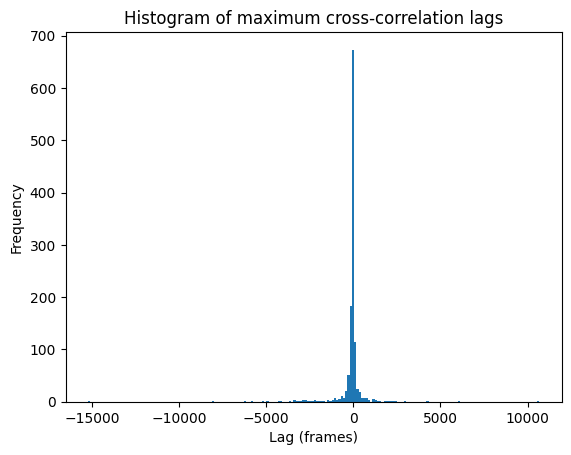

In [186]:
plt.hist(df['max_lag'], bins=200)
plt.xlabel('Lag (frames)')
plt.ylabel('Frequency')
plt.title('Histogram of maximum cross-correlation lags')
plt.show()

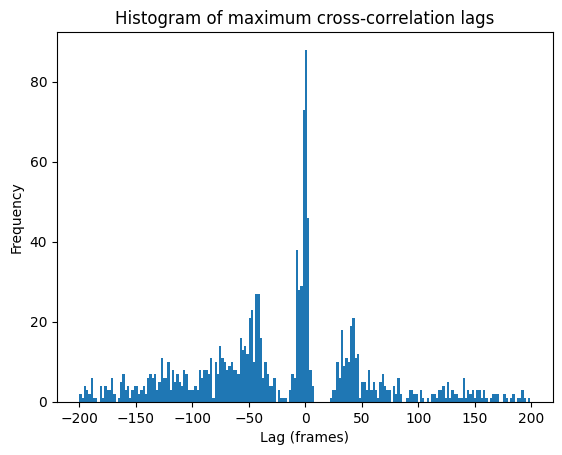

In [193]:
plt.hist(df['max_lag_200'], bins=200)
plt.xlabel('Lag (frames)')
plt.ylabel('Frequency')
plt.title('Histogram of maximum cross-correlation lags')
plt.show()

In [189]:
df

,file_name,max_lag,max_lag_200,max_lag_100,max_lag_50,max_lag_25
0,TR6R91L11C8A40D710,-66,-67,-67,49,-23
1,TRACGVT149E3B9BE3F,-2,-3,-3,-3,-3
2,TRACPPB149E33C10B9,-3,-4,-4,-4,-4
3,TRADINA127F847B84E,-87,-88,-88,-7,-7
4,TRAEQJQ149E3BA694B,-40,-41,-41,-41,-1
...,...,...,...,...,...,...
1212,TRZUUDG149E37F179C,-93,-94,-94,-10,-10
1213,TRZUXXY149E39C2D8E,3,2,2,2,2
1214,TRZWERX149E381FF71,-121,-122,-35,-35,1
1215,TRZWISM149E35CA148,-107,-108,-37,-37,-1
